In [95]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

In [96]:
# Load dataset
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.ToTensor(),
])

batch_size = 4

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size, shuffle=True)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size, shuffle=True)

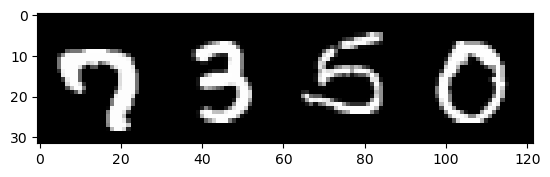

Seven Three Five  Zero 
None


In [97]:
import matplotlib.pyplot as plt

classes = ('Zero', 'One', 'Two', 'Three', 'Four', 'Five', 'Six', 'Seven', 'Eight', 'Nine')

def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print(print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size))))

In [98]:
images[0].shape

torch.Size([1, 28, 28])

In [99]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [100]:

def loss_function(x_reconstructed, x, mu, log_var):
    BCE = F.binary_cross_entropy(x_reconstructed, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

    return BCE + KLD

In [108]:
def train(epoch, model, optimizer):
    model.train()
    train_loss = 0

    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()

        reconstructed_x, mu, log_var = model(data)
        loss = loss_function(reconstructed_x, data, mu, log_var)

        loss.backward()
        train_loss += loss.item()
        optimizer.step()

        if batch_idx % 1000 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item() / len(data)))
            print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))

In [109]:
def test(model):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for data, _ in test_loader:
            data = data.to(device)
            r_x, mu, log_var = model(data)
            test_loss += loss_function(r_x, data, mu, log_var)
        
        test_loss /= len(test_loader.dataset)
        print('====> Test set loss: {:.4f}'.format(test_loss))


In [115]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        
        # Encoder 1x28x28
        self.conv1 = nn.Conv2d(1, 1, 3, padding=0) #1x26x26
        self.conv2 = nn.Conv2d(1, 1, 3, padding=0) #1x24x24
        self.conv3 = nn.Conv2d(1, 1, 5, padding=0) # 1x20x20
        self.conv4 = nn.Conv2d(1, 1, 5, padding=0) #1x16x16

        # Latent
        self.fc1 = nn.Linear(256, 128)
        self.fc21 = nn.Linear(128, 64)
        self.fc22 = nn.Linear(128, 64)
        
        # Decoder 1x64
        self.fc3 = nn.Linear(64, 128) # 1x128
        self.fc4 = nn.Linear(128, 256) # 1x256
        self.conv5 = nn.Conv2d(1, 1, 3, padding=2) # 1x18x18
        self.conv6 = nn.Conv2d(1, 1, 3, padding=2) # 1x20x20
        self.conv7 = nn.Conv2d(1, 1, 3, padding=3) # 1x24x24
        self.conv8 = nn.Conv2d(1, 1, 3, padding=3) # 1x28x28

    def encoder(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))    

        x_flat = torch.flatten(x, start_dim=1)
        x = self.fc1(x_flat)

        return self.fc21(x), self.fc22(x) # mu, log_var
    
    def sampling(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu) # 1x
    
    def decoder(self, x):
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))

        x = x.view(-1, 1, 16, 16)
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        x = F.relu(self.conv7(x))
        x = F.relu(self.conv8(x))

        return F.sigmoid(x)
    
    def forward(self, x):
        mu, log_var = self.encoder(x)
        latent_z = self.sampling(mu, log_var)
        return self.decoder(latent_z), mu, log_var
    
    
vae = VAE().to(device)

In [116]:
import torch.optim as optim

optimizer = optim.Adam(vae.parameters())

In [117]:
for epoch in range(1, 5):
    train(epoch, vae, optimizer)
    test(vae)

Train Epoch: 1 [0/60000 (0%)]	Loss: 543.582764
====> Epoch: 1 Average loss: 0.0362
Train Epoch: 1 [4000/60000 (7%)]	Loss: 543.427429
====> Epoch: 1 Average loss: 36.2648
Train Epoch: 1 [8000/60000 (13%)]	Loss: 543.427429
====> Epoch: 1 Average loss: 72.4933
Train Epoch: 1 [12000/60000 (20%)]	Loss: 543.427429
====> Epoch: 1 Average loss: 108.7218
Train Epoch: 1 [16000/60000 (27%)]	Loss: 543.427429
====> Epoch: 1 Average loss: 144.9503
Train Epoch: 1 [20000/60000 (33%)]	Loss: 543.427429
====> Epoch: 1 Average loss: 181.1788
Train Epoch: 1 [24000/60000 (40%)]	Loss: 543.427429
====> Epoch: 1 Average loss: 217.4073
Train Epoch: 1 [28000/60000 (47%)]	Loss: 543.427429
====> Epoch: 1 Average loss: 253.6358
Train Epoch: 1 [32000/60000 (53%)]	Loss: 543.427429
====> Epoch: 1 Average loss: 289.8642
Train Epoch: 1 [36000/60000 (60%)]	Loss: 543.427429
====> Epoch: 1 Average loss: 326.0927
Train Epoch: 1 [40000/60000 (67%)]	Loss: 543.427429
====> Epoch: 1 Average loss: 362.3212
Train Epoch: 1 [44000/